<a href="https://colab.research.google.com/github/PXDHU/CNN/blob/main/Multi_class_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-class Classification

We will be using the [Sign Language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist) dataset, which contains 28x28 images of hands depicting the 26 letters of the english alphabet. 

We will need to pre-process the data so that it can be fed into our convolutional neural network to correctly classify each image as the letter it represents.

In [1]:
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

Download the training and test sets (the test set will actually be used as a validation set):

In [2]:
# sign_mnist_train.csv
!gdown --id 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown --id 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
To: /content/sign_mnist_train.csv
100% 83.3M/83.3M [00:00<00:00, 256MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg
To: /content/sign_mnist_test.csv
100% 21.8M/21.8M [00:00<00:00, 230MB/s]


Define some globals with the path to both files you just downloaded:

In [3]:
TRAINING_FILE = './sign_mnist_train.csv'
VALIDATION_FILE = './sign_mnist_test.csv'

In [4]:
with open(TRAINING_FILE) as training_file:
  line = training_file.readline()
  print(f"First line (header) looks like this:\n{line}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pix

As we can see, each file includes a header (the first line) and each subsequent data point is represented as a line that contains 785 values. 

The first value is the label (the numeric representation of each letter) and the other 784 values are the value of each pixel of the image. Remember that the original images have a resolution of 28x28, which sums up to 784 pixels.

 ## Parsing the dataset
 

 This function reads a file passed as input and return 2 numpy arrays, one containing the labels and one containing the 28x28 representation of each image within the file. These numpy arrays should have type `float64`.

 A couple of things to keep in mind:
 
- The first line contains the column headers, so you should ignore it.

- Each successive line contains 785 comma-separated values between 0 and 255
  - The first value is the label

  - The rest are the pixel values for that picture

In [6]:
def parse_data_from_input(filename):
  """
  Parses the images and labels from a CSV file
  
  Args:
    filename (string): path to the CSV file
    
  Returns:
    images, labels: tuple of numpy arrays containing the images and labels
  """
  with open(filename) as file:

    # Using csv.reader, passing in the appropriate delimiter
    # csv.reader can be iterated and returns one line in each iteration
    csv_reader = csv.reader(file, delimiter=',')
    first_line = True 
    temp_images = []
    temp_labels = []
    for row in csv_reader:
      if first_line:
        first_line = False
      else:
        temp_labels.append(row[0])
        image_data = row[1:785]
        image_data_as_array = np.array_split(image_data, 28)
        temp_images.append(image_data_as_array)
    labels = np.array(temp_labels).astype('float')
    images = np.array(temp_images).astype('float')

    return images, labels

In [7]:
# Test your function
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64


## Visualizing the numpy arrays

The images of the dataset look like:

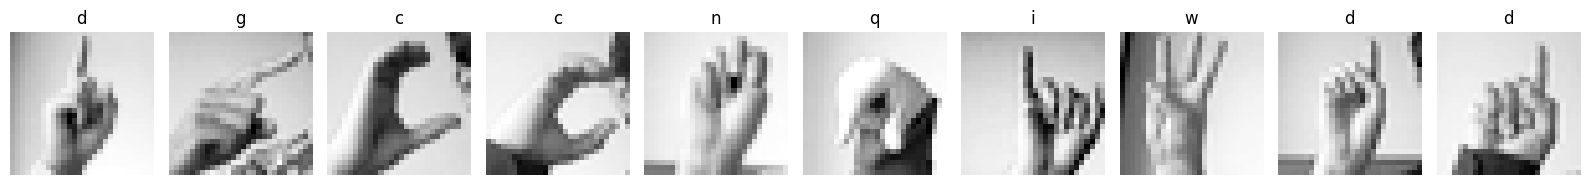

In [8]:
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

## Creating the generators for the CNN



In [9]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  """
  Creates the training and validation data generators
  
  Args:
    training_images (array): parsed images from the train CSV file
    training_labels (array): parsed labels from the train CSV file
    validation_images (array): parsed images from the test CSV file
    validation_labels (array): parsed labels from the test CSV file
    
  Returns:
    train_generator, validation_generator - tuple containing the generators
  """


  # Add another dimension to the data
  # np.expand_dims
  training_images = np.expand_dims(training_images, axis=3)
  validation_images = np.expand_dims(validation_images, axis=3)

  # Instantiate the ImageDataGenerator class 
  # Normalize pixel values 
  # Set arguments to augment the images (if desired)
  train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


  # Pass in the appropriate arguments to the flow method
  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=32) 

  
  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # Remember that validation data should not be augmented
  validation_datagen = ImageDataGenerator(
    rescale=1. / 255)

  # Pass in the appropriate arguments to the flow method
  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=32) 

  return train_generator, validation_generator

In [10]:
# Test your generators
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)


## Coding the CNN


In [11]:
def create_model():     

  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(26, activation=tf.nn.softmax)])
  

  model.compile(optimizer = 'rmsprop',
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
      
  
  return model

In [12]:
# Save your model
model = create_model()

# Train your model
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

Epoch 1/15
858/858 [==============================] - 24s 16ms/step - loss: 2.8648 - accuracy: 0.1378 - val_loss: 2.3427 - val_accuracy: 0.2476
Epoch 2/15
858/858 [==============================] - 14s 16ms/step - loss: 2.2279 - accuracy: 0.3040 - val_loss: 1.3515 - val_accuracy: 0.5607
Epoch 3/15
858/858 [==============================] - 13s 16ms/step - loss: 1.7693 - accuracy: 0.4336 - val_loss: 1.2351 - val_accuracy: 0.5864
Epoch 4/15
858/858 [==============================] - 14s 16ms/step - loss: 1.4390 - accuracy: 0.5392 - val_loss: 1.0207 - val_accuracy: 0.6606
Epoch 5/15
858/858 [==============================] - 13s 16ms/step - loss: 1.2047 - accuracy: 0.6082 - val_loss: 0.6965 - val_accuracy: 0.7384
Epoch 6/15
858/858 [==============================] - 14s 16ms/step - loss: 1.0364 - accuracy: 0.6611 - val_loss: 0.6402 - val_accuracy: 0.7607
Epoch 7/15
858/858 [==============================] - 14s 17ms/step - loss: 0.9174 - accuracy: 0.6985 - val_loss: 0.5350 - val_accuracy:

Now take a look at your training history:

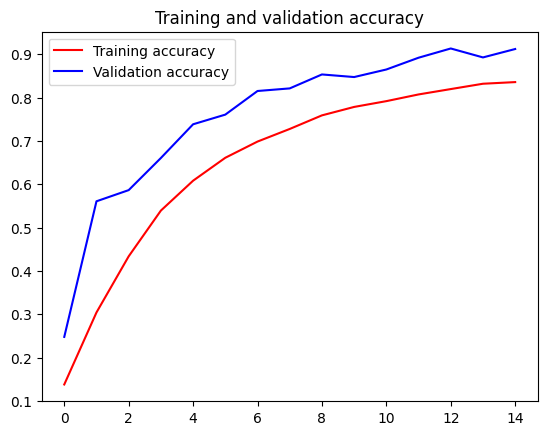

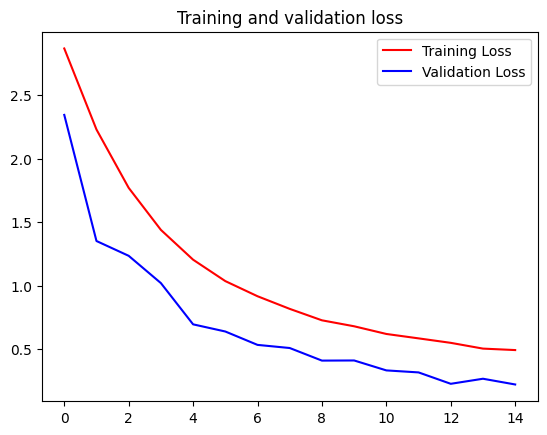

In [13]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()